# Yolo Prediction NoteBook

In [ ]:
import numpy as np
import os 
import pandas as pd

import cv2

import matplotlib.pyplot as plt
from keras.utils import load_img,img_to_array

In [ ]:
# Setting Up Image 
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [ ]:
os.getcwd()
os.chdir(r'G:\DeepLearning Projects\Udemy-LicensePlateDetection')
os.getcwd()

'g:\\DeepLearning Projects\\Udemy-LicensePlateDetection'

### LOAD THE IMAGE

In [ ]:

path = r'.\images_labeled\\N7.jpeg'
image = load_img(path)
image = np.array(image,dtype=np.uint8)

image1 = load_img(path,target_size=(224,224))
image1_arr = img_to_array(image1)/225.0 #Normalizing the image

cv2.namedWindow("Loaded Image", cv2.WINDOW_KEEPRATIO)
cv2.imshow("Loaded Image",image)
cv2.waitKey()
cv2.destroyAllWindows()


### Loading the Trained Model

In [ ]:
net= cv2.dnn.readNetFromONNX('best12.onnx')
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

## Helper Functions

### Get detections 

In [ ]:
def get_detections(img, net):
    
    # Convert Image to YOLO input
    image = img.copy()
    row,col,d = image.shape
    max_rc = max(row,col)
    input_image=np.zeros((max_rc,max_rc,3),dtype=np.uint8)
    input_image[0:row,0:col]=image


    #Get Prediction from YOLO model
    
    blob = cv2.dnn.blobFromImage(input_image,1./255,(640,640),swapRB=True,crop=False)
    net.setInput(blob)
    pred= net.forward()
    detection = pred[0]

    return detection,input_image

### Get Non Maximum Superssion

In [ ]:
def non_maximum_supression(input_image,detection):
    #Getting the Bounding Boxes
    boxes =[]
    confidences = []

    image_w,image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT


    for i in range(len(detection)):
        row =detection[i]
        confidence = row[4]

        if confidence >0.4:
            class_score = row[5]
            if class_score>0.25:
                cx, cy , w, h = row[0:4]
                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])

                confidences.append(confidence)
                boxes.append(box)
    
    #To get list of arrays(clean)
    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()    

    index =cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45).flatten() #SCORE THRESHOLD,#nms THRESHOLD

    return boxes_np,confidences_np, index

### Get Boundin Boxes on the Image

In [ ]:

def drawings(image,boxes_np,confidences_np,indexes):
    # Drawing the Index
    for i in indexes:
        bb_box = boxes_np[i]
        conf = confidences_np[i]
        x,y,w,h = bb_box
        
        conf_text = 'License plate: {:.2f}%'.format(conf*100)
        license_text = extract_text(image,bb_box)
        
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.rectangle(image,(x,y-30),(x+w,y),(255,0,255),-1)
        cv2.rectangle(image,(x,y+h),(x+w,y+h+30),(0,0,0),-1)


        cv2.putText(image,conf_text,(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.7,(255,255,255),3)
        cv2.putText(image,license_text,(x,y+h+27),cv2.FONT_HERSHEY_SIMPLEX,0.7,(0,255,0),3)
 #image_rgb = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        #plt.imshow(image)
        #plt.show()

    return image,license_text

### Extract the Text from the Images 

In [ ]:
import pytesseract as pt

def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h,x:x+w]
    #plt.imshow(roi)
    #plt.show()

    if 0 in roi.shape:
        return ''
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        return text


## Predict Function with all the helper funcitons

In [ ]:
def yolo_prediction(image,net):
    #Predictions
    detections, input_image = get_detections(image,net)

    #get bounding boxes
    boxes_np,confidences_np,index = non_maximum_supression(input_image,detections)

    #Drawing Rectangle
    result_img,text = drawings(image,boxes_np,confidences_np,index)
    print("The Licence Text: {}".format(text))
    plt.imshow(result_img)  
    plt.show()

## Load the Image

In [ ]:
path = r'Test_Images\15.jpg'
image = load_img(path)
image = np.array(image,dtype=np.uint8)
image1 = load_img(path,target_size=(224,224))
image1_arr = img_to_array(image1)/225.0 #Normalizing the image

cv2.namedWindow("result",cv2.WINDOW_KEEPRATIO)
cv2.imshow("result",image)
cv2.waitKey()
cv2.destroyAllWindows()

The Licence Text: UL7C N 5617


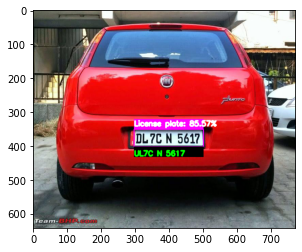

In [ ]:
yolo_prediction(image,net)